In [1]:
import numpy as np
from matplotlib import pyplot as plt
from basicpy import BaSiC
from itertools import product
import os
# import logging
# logging.getLogger("basicpy").setLevel(level=logging.WARNING)



Bad key text.latex.unicode in file /Users/fukai/.matplotlib/stylelib/paper-default2.mplstyle, line 46 ('text.latex.unicode: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution
Duplicate key in file PosixPath('/Users/fukai/.matplotlib/stylelib/paper-default.mplstyle'), line 38 ('legend.framealpha: 1.0')
the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","OPENCV","SCIPY"]


# Synthetic data test

In [2]:
n_images = 8
basic = BaSiC(get_darkfield=False,lambda_flatfield_coef=0.5,max_reweighting_iteration=0,max_iterations=2000)

"""Generate a parabolic gradient to simulate uneven illumination"""
# Create a gradient
size = basic.working_size
grid = np.meshgrid(*(2 * (np.linspace(-size // 2 + 1, size // 2, size),)))
gradient = sum(d**2 for d in grid)
gradient = 0.01 * (np.max(gradient) - gradient) + 10
gradient_int = gradient.astype(np.uint8)

# Ground truth, for correctness checking
truth = gradient / gradient.mean()

# Create an image stack and add poisson noise
synthetic_images = np.random.poisson(lam=gradient_int.flatten(), size=(n_images, size**2)).reshape((n_images, size, size))

INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 4.877019455307163e-05.
INFO:basicpy.basicpy:mean of S: 0.9429211616516113.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:reweighting iteration 1
INFO:basicpy.basicpy:single-step optimization score: 4.9432783271186054e-05.
INFO:basicpy.basicpy:mean of S: 0.9425277709960938.
INFO:basicpy.basicpy:Iteration 1 finished.
INFO:basicpy.basicpy:reweighting score: 0.010392827913165092
INFO:basicpy.basicpy:elapsed time: 40.944833141 seconds
INFO:basicpy.basicpy:reweighting iteration 2
INFO:basicpy.basicpy:single-step optimization score: 4.992282629245892e-05.
INFO:basicpy.basicpy:mean of S: 0.9423526525497437.
INFO:basicpy.basicpy:Iteration 2 finished.
INFO:basicpy.basicpy:reweighting score: 0.004226401913911104
INFO:basicpy.basicpy:elapsed time: 53.322688568 seconds
INFO:basicpy.basicpy:Reweighting converged.
INFO:basicpy.basicpy:=== BaSiC fit finished in 53.340653055 seconds ===


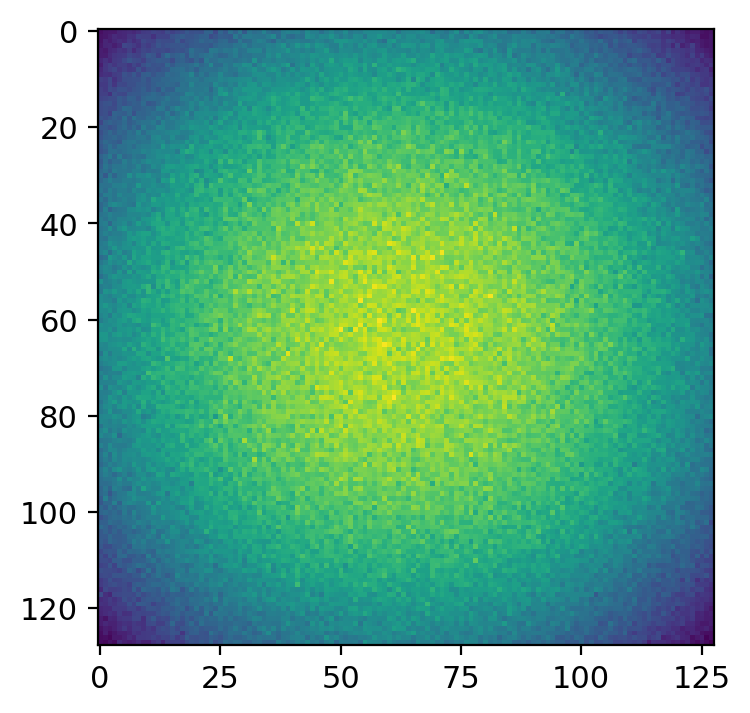

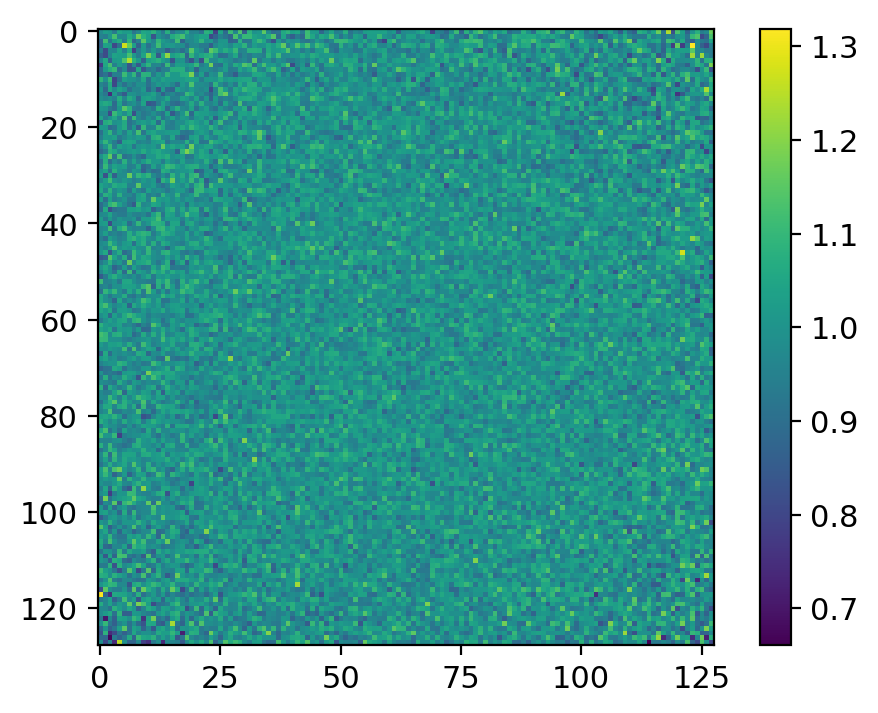

In [3]:
"""Fit with BaSiC"""
basic.fit(synthetic_images)
plt.imshow(basic.flatfield)
plt.show()
plt.imshow(basic.flatfield/truth) ; plt.colorbar() ; plt.show()

# Exporting data for test

(147, 128, 128) uint16


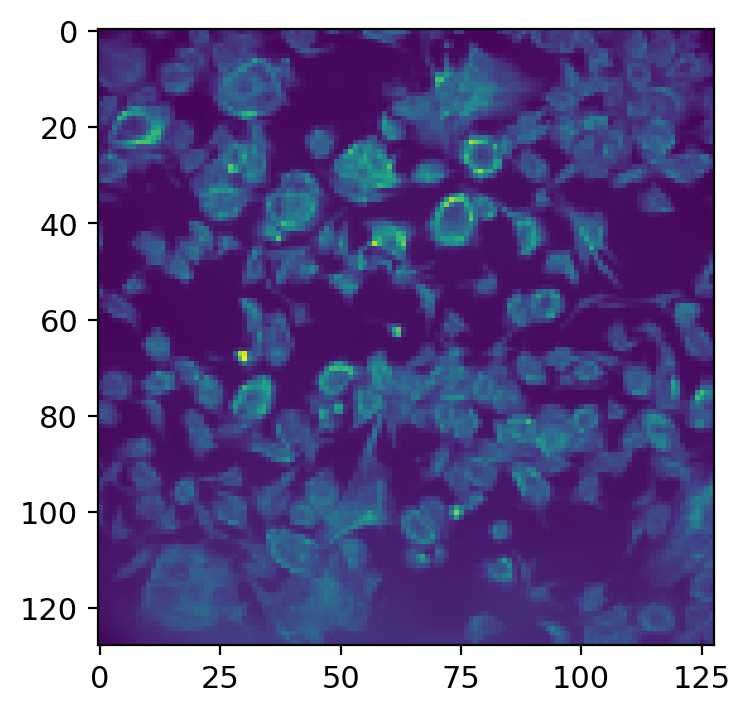

(100, 128, 171) uint8


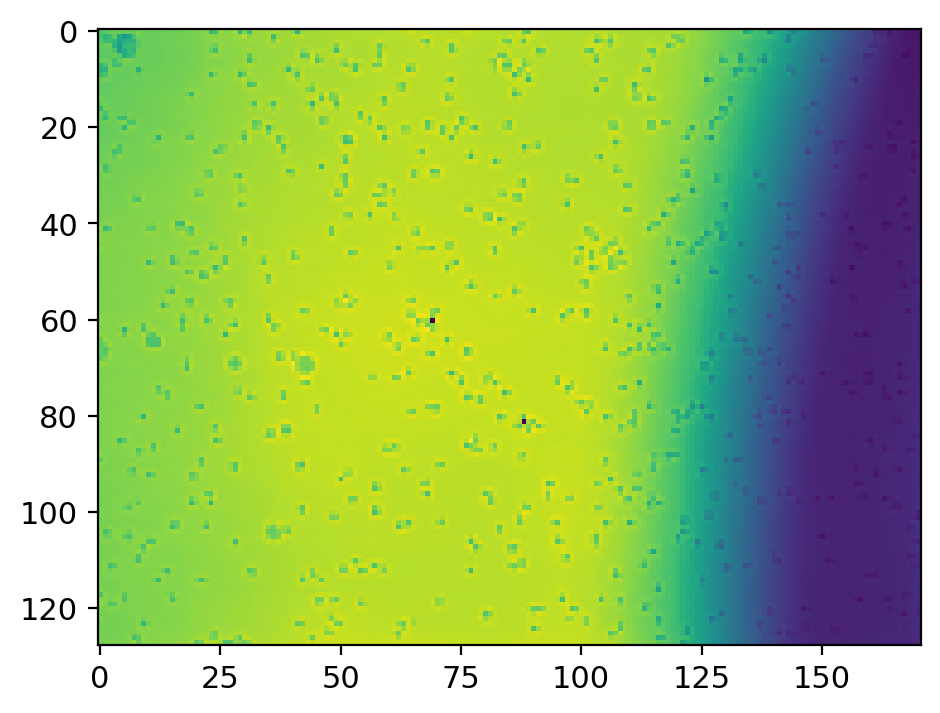

(189, 128, 171) uint8


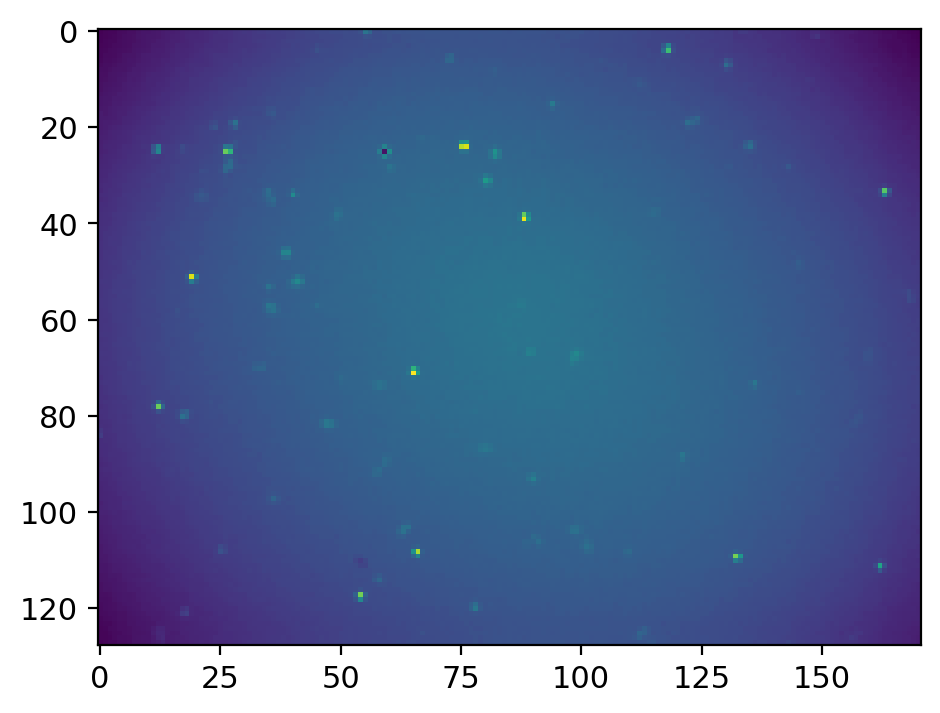

(200, 128, 171) uint8


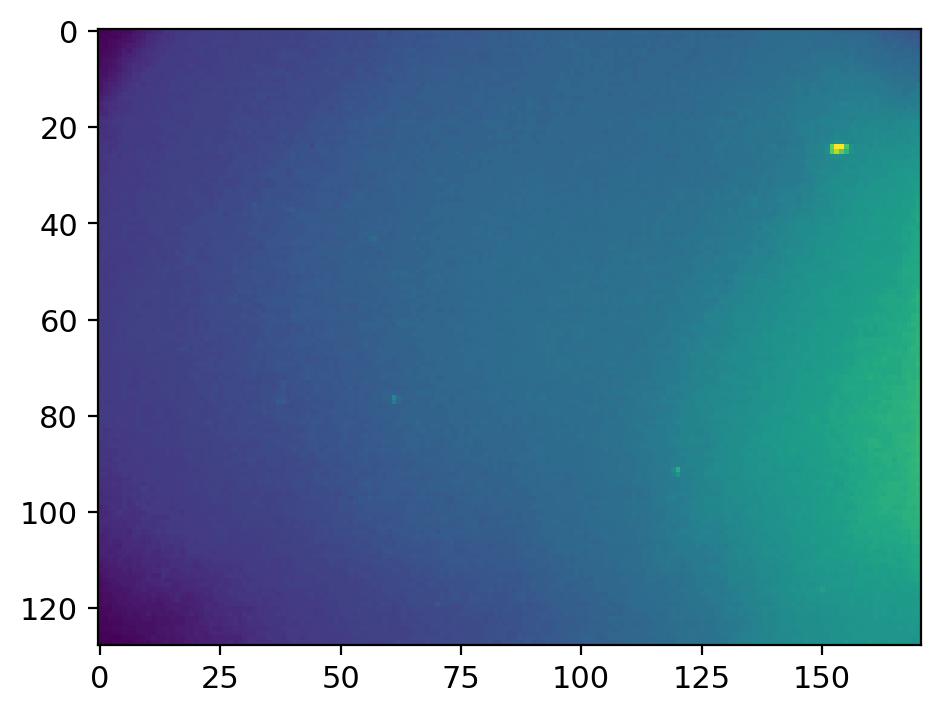

(63, 128, 128) uint16


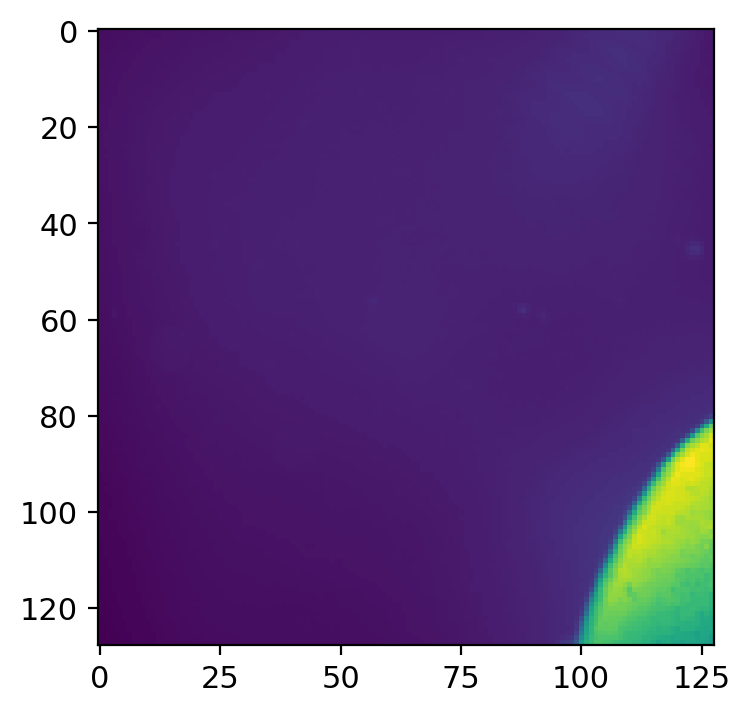

In [4]:
images = {}
keys = ["cell_culture","timelapse_brightfield","timelapse_nanog","timelapse_pu1","wsi_brain"]
for k in keys:
    d=np.load(f"../data/{k}.npz")
    im=d["images"]
    print(im.shape, im.dtype)
    plt.imshow(im[10])
    images[k]=im
    plt.show()

INFO:basicpy.basicpy:Initializing BaSiC 5247032512 with parameters: 
fitting_mode: ladmap
lambda_flatfield_coef: 1.0
rho: 1.8
max_reweight_iterations: 5
max_iterations: 2000
get_darkfield: False
sort_intensity: False

INFO:basicpy.basicpy:=== BaSiC fit started ===
INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 6.105691454649786e-07.
INFO:basicpy.basicpy:mean of S: 0.9758407473564148.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:reweighting iteration 1
INFO:basicpy.basicpy:single-step optimization score: 7.470076752724708e-07.
INFO:basicpy.basicpy:mean of S: 0.9778785109519958.
INFO:basicpy.basicpy:Iteration 1 finished.
INFO:basicpy.basicpy:reweighting score: 0.022462083026766777
INFO:basicpy.basicpy:elapsed time: 16.804242344000002 seconds
INFO:basicpy.basicpy:reweighting iteration 2
INFO:basicpy.basicpy:single-step optimization score: 8.153051567205694e-07.
INFO:basicpy.basicpy:mean of S: 0.9783413410186768.
INFO:ba

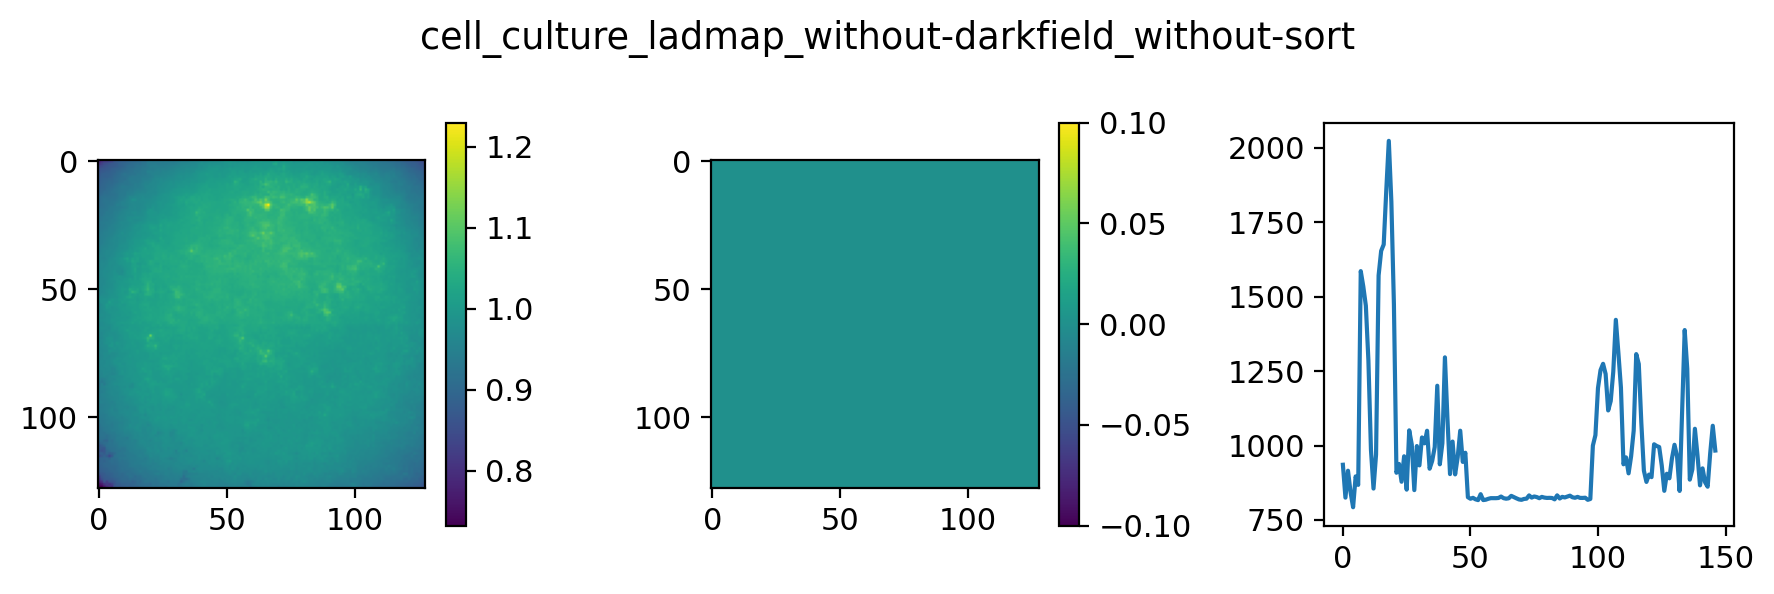

In [5]:
os.makedirs("../tests/data/fit", exist_ok=True)

for k,im in images.items():
    for fitting_mode, get_darkfield, sort_intensity in \
        product(["ladmap","approximate"],[False,True],[False,True]):
        b = BaSiC(fitting_mode=fitting_mode, 
                  lambda_flatfield_coef=1.0 / 400 * 0.5 if fitting_mode=="approximate" else 1.,
#                  lambda_darkfield_coef=0.2 if fitting_mode=="approximate" else 0.2,
                  rho=1.8,
                  max_reweight_iterations=5,
                  max_iterations=2000,
                  get_darkfield=get_darkfield, 
                  sort_intensity=sort_intensity)
        b.fit(im)
        plt.figure(figsize=(9,3))
        plt.subplot(131)
        plt.imshow(b.flatfield)
        plt.colorbar()
        plt.subplot(132)
        plt.imshow(b.darkfield)
        plt.colorbar()
        plt.subplot(133)
        plt.plot(b.baseline)
        boolstr = lambda x:"with" if x else "without"
        k2=f"{k}_{fitting_mode}_{boolstr(get_darkfield)}-darkfield_{boolstr(sort_intensity)}-sort"
        plt.suptitle(k2)
        plt.tight_layout()
        plt.savefig(f"../tests/data/fit/plots/{k2}.png")
        plt.show()
        np.savez_compressed(f"../tests/data/fit/{k2}.npz",
            image_name=k,
            flatfield=b.flatfield,
            darkfield=b.darkfield,
            baseline=b.baseline,
            params=b.dict()
        )
        break
    break

In [6]:

np.mean(b.flatfield)

DeviceArray(0.9999999, dtype=float32)

In [7]:
np.mean(b.flatfield)

DeviceArray(0.9999999, dtype=float32)